<img src="py-logo.png" width="100pt"/>


# INTRODUCTION TO PYTHON 
# V – PREDICTIVE MODELING
*Lasse Ruokolainen*

*Seasoned Data Master, BILOT Consulting Oy* 

***

# (1) HOLDOUT METHOD
When training predictive models, it is common practice to *split* the data and use only one part for the training. This is done to facilitate the evaluation of the generality of the model. As an example, we will here use a data set that contains information on credit defaults. 

### (a) *Data preparation*

In [1]:
import pandas as pd
df = pd.read_csv('Datasets/german_credit_data.csv', sep=';')
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Default
0,67,male,2,own,NaN,little,1169,6,radio/TV,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,2
2,49,male,1,own,little,NaN,2096,12,education,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,2


In [2]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
Age                 1000 non-null int64
Sex                 1000 non-null object
Job                 1000 non-null int64
Housing             1000 non-null object
Saving accounts     817 non-null object
Checking account    606 non-null object
Credit amount       1000 non-null int64
Duration            1000 non-null int64
Purpose             1000 non-null object
Default             1000 non-null int64
dtypes: int64(5), object(5)
memory usage: 78.2+ KB
None


Notice that there are several missing values in two categorical features. A good way to proceed is to replace them with 'missing': 

In [6]:
df_imputed = df.fillna('missing')
print(df_imputed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
Age                 1000 non-null int64
Sex                 1000 non-null object
Job                 1000 non-null int64
Housing             1000 non-null object
Saving accounts     1000 non-null object
Checking account    1000 non-null object
Credit amount       1000 non-null int64
Duration            1000 non-null int64
Purpose             1000 non-null object
Default             1000 non-null int64
dtypes: int64(5), object(5)
memory usage: 78.2+ KB
None


Next we need to make the response variable categorical:

In [7]:
df_imputed['Default'] = df_imputed['Default'].map({1:'no',2:'yes'})
print(df_imputed['Default'].head())

0     no
1    yes
2     no
3     no
4    yes
Name: Default, dtype: object


Now that the data is in order, we need to still transform it in a form useable to `sklearn`:

In [8]:
# response / label:
Y = df_imputed['Default']
# predictors:
X = df_imputed.drop('Default',axis=1)

# convert factor to binary form:
X = pd.get_dummies(X,drop_first=True)

X.head()
print(df_imputed.shape)
print(X.shape)

(1000, 10)
(1000, 21)


### (b) *Splitting the data*
Having the data prepared, we can now procede to splitting the data. While there is now definite rule for choosing the splitting proportion, usually a fraction between 0.7-0.8 is used for the training set. 

In [9]:
# define a random training set:
import numpy as np
from random import sample

p_train = 0.8 # proportion of examples allocated to training
indices = sample(range(X.shape[0]),round(X.shape[0] * p_train))
indices[0:10]

[485, 710, 239, 505, 539, 323, 45, 672, 731, 839]

In [10]:
# split and convert to array:
X_train = X.iloc[indices,:].values
X_test = X.drop(indices).values

Y_train = Y.iloc[indices].values
Y_test = Y.drop(indices).values

# print the resulting proportions:
print('Proportion training: %.2f' %(X_train.shape[0]/X.shape[0]))
print('Proportion testing: %.2f' %(X_test.shape[0]/X.shape[0]))

Proportion training: 0.80
Proportion testing: 0.20


Good stuff, we have managed make a random split of the data, and the size of the training and testing sets match with what we expected to get. We are now all set for building some predictive models.

## (2) MODEL TRAINING

In this section we will try to build a model that is able to predict the response variabe, with an acceptable accuracy. We have alrewady prepared the data and we are ready to proceed. All we need now is to load some methods from `sklearn` and put them into use. Remember that in the example data, the response variable is categorical (yes/no), which means that we are faced with a *classification problem*.

### (a) *Logistic regression*
Do not overlook the utility of simple methods. Logistic regression is an exellent method for benchmarking predictability, as there is practically no risk of overfitting and you also get interpretable estimates of the role of different predictors.

In [13]:
# get the logistic regression model:
from sklearn.linear_model import LogisticRegression

# define a model object:
model_logistic = LogisticRegression(solver = 'lbfgs',max_iter=200)

# fit the model using the training data:
model_logistic.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

Now that we have the model trained, we need to evaluate how well the model performs in classifying the response variable. This we do by predicting the outcome, using the training set:

In [14]:
result = model_logistic.score(X_train,Y_train)
print('Accuracy: %.2f' %result)

Accuracy: 0.77


Good, now we have something to compare to. 

We can also visualise the model coefficients, as we did in the **Statistics** section. This can be usefull when trying to understand which factors most strongly affect the outcome and whether their effect is positive or negative.

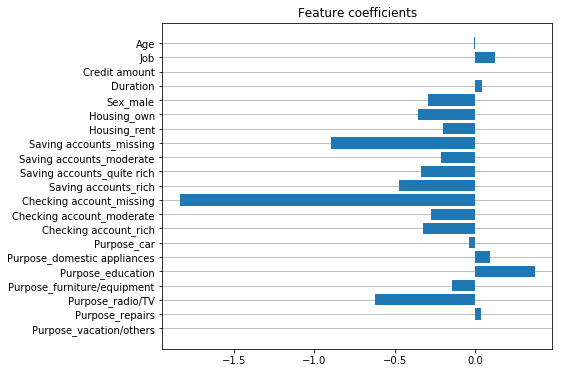

In [16]:
import matplotlib.pyplot as plt

# plot model coefficients:
fig, ax = plt.subplots(figsize=(7,6))
ax.barh(X.columns,model_logistic.coef_[0,:],orientation='horizontal')
ax.invert_yaxis()
ax.grid(color='gray', linestyle='-', linewidth=0.5,axis='y')
ax.set_axisbelow(True)
plt.title('Feature coefficients')
plt.show()

### (b) *Decision tree classifier*

Decision Trees are a non-parametric (supervised learning) methods, used for classification and regression. The goal is to create a model that predicts the value of a responce variable by learning simple decision rules inferred from the data features. What is good about them is that they are simple to understand and to interpret and the trees can be visualised. On the down side, decision-tree learners can create over-complex trees that do not generalise the data well. This is called overfitting (we'll get back to this later).

In [17]:
from sklearn.tree import DecisionTreeClassifier as DT

model_tree = DT(criterion='entropy',max_depth=12)

model_tree.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [18]:
result = model_tree.score(X_train,Y_train)
print('Accuracy: %.2f' %result)

Accuracy: 0.92


Wow! This looks amazing, we were able to correctly classify nearly every example. But, recall that decision trees easily overfitt the data, which means we should be cautious here.

The decision tree classifier also provides an estima of feature importances:

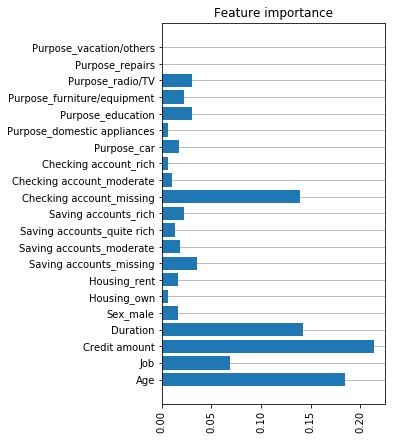

In [25]:
# plot feature importances:
fig, ax = plt.subplots(figsize=(4,7))
ax.barh(X.columns,model_tree.feature_importances_,orientation='horizontal')
ax.grid(color='gray', linestyle='-', linewidth=0.5,axis='y')
ax.set_axisbelow(True)
plt.xticks(rotation=90)
plt.title('Feature importance')
plt.show()

The decision tree topology can be visualised as follows:

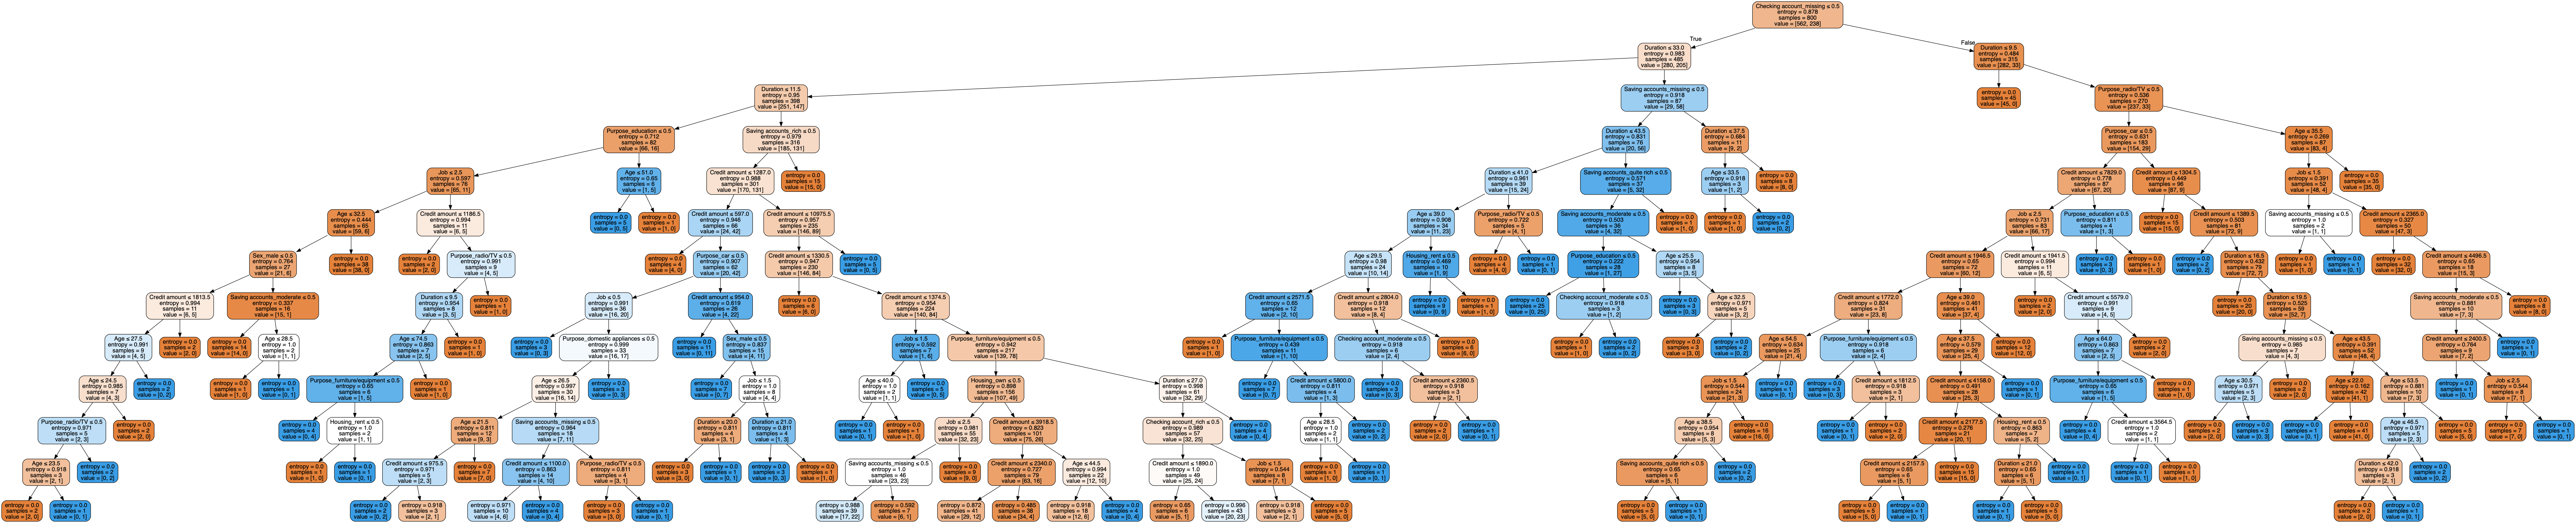

In [28]:
import graphviz
from sklearn.externals.six import StringIO 
from sklearn.tree import export_graphviz
from IPython.display import Image 
import pydotplus

dot_data = StringIO()
export_graphviz(model_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names=X.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

The graph is quite big, which is due to the fact that categorical features have been binary-coded.

## (3) MODEL EVALUATION
We start by producing model predictions (i.e., the predicted outcome) using the training set. In order to reduce the amount of code, the results for each model will be stored in a dictionary, from where they can be easily accessed.

In [29]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# generate model predictions for training and store them in a dictionary:
pred_tr = dict()
pred_tr['logistic'] = model_logistic.predict(X_train)
pred_tr['tree'] = model_tree.predict(X_train)

pred_tr_p = dict()
pred_tr_p['logistic'] = model_logistic.predict_proba(X_train)[:,1]
pred_tr_p['tree'] = model_tree.predict_proba(X_train)[:,1]

### (a) *Confusion matrix*
Having the model predictions ready, we can calculate the *confusion matrix* for each model, by looping through the dictionary of predicted values:

In [30]:
# calculate the confusion matrices:
conf = dict()
for i in pred_tr.keys():
    conf[i] = confusion_matrix(Y_train,pred_tr[i])

print('Logistic regression: \n',conf['logistic'], '\n')
print('Decision tree: \n',conf['tree'])

Logistic regression: 
 [[516  46]
 [142  96]] 

Decision tree: 
 [[521  41]
 [ 26 212]]


The confusion matrix is a simpke cross-tabulation of the *observed* and *predicted* outcomes. On the diagonal we have correctly classified examples (i.e., observed and predicted match) and on the off-diagonal we have misclassified examples. Try calculate model accuracies yourself, using the confusion matrices.

### (b) *Receiver Operator Characteristic*

The following code calculates the *false positive rate* and *true positive rate*, for different cut-off points along predicted class probabilities, for each model. Within the for-loop, also *AUC* (Area Under Curve) metric is calculated, based on the `fpr` and `tpr` values:

In [32]:
fpr, tpr,thresholds = dict(), dict(), dict()
roc_auc = dict()
for i in pred_tr.keys():
    fpr[i], tpr[i], thresholds[i] = roc_curve(Y_train, pred_tr_p[i], pos_label='yes')
    roc_auc[i] = auc(fpr[i], tpr[i]).round(3)

print(roc_auc)

{'logistic': 0.789, 'tree': 0.978}


When these values have been obtained, we can plot the *ROC curves* for each model. The `enumerate` function is very convenient, as it returns the input values along with their index locations.

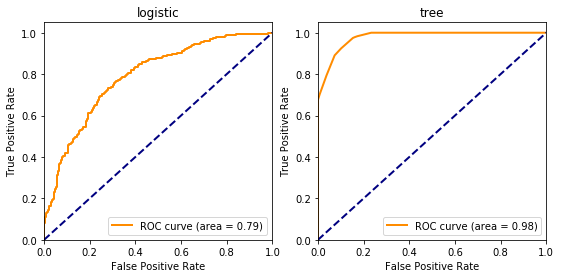

In [33]:
plt.figure(figsize=(9,4))
for ind,i in enumerate(fpr.keys()):
    plt.subplot(1,2,ind+1)
    plt.plot(fpr[i], tpr[i], color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(i)
    plt.legend(loc="lower right")
plt.show()

The blue dashed lines in the plots indicate the case of fully random prediction, i.e., coin tossing; the higher the orange line sits above this reference line, the better the model is in differentiating between outcomes. 

### (c) *Model testing*


In [34]:
result = model_logistic.score(X_test,Y_test), model_tree.score(X_test,Y_test)

print('Logistic model, testing accuracy: %.2f' %result[0])
print('Decision tree model, testing accuracy: %.2f' %result[1])

Logistic model, testing accuracy: 0.68
Decision tree model, testing accuracy: 0.69


Looks like our decision tree model was not that good after all, whereas the accuracy is practically the same for logistic regression. Let's next compare the *ROC curves* between data sets: 

In [36]:
# generate model predictions for testing and store them in a dictionary:
pred_ts = dict()
pred_ts['logistic'] = model_logistic.predict_proba(X_test)[:,1]
pred_ts['tree'] = model_tree.predict_proba(X_test)[:,1]

fpr2, tpr2,thresholds2 = dict(), dict(), dict()
roc_auc2 = dict()
for i in pred_ts.keys():
    fpr2[i], tpr2[i], thresholds2[i] = roc_curve(Y_test, pred_ts[i], 
                                                 pos_label='yes')
    roc_auc2[i] = auc(fpr2[i], tpr2[i]).round(3)

print(roc_auc2)

{'logistic': 0.695, 'tree': 0.647}


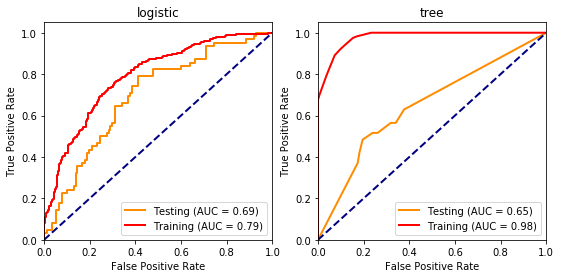

In [37]:
# plot ROC curves for both training and testing data:
plt.figure(figsize=(9,4))
for ind,i in enumerate(fpr.keys(),1):
    plt.subplot(1,2,ind)
    plt.plot(fpr2[i], tpr2[i], color='darkorange',
         lw=2, label='Testing (AUC = %0.2f)' % roc_auc2[i])
    plt.plot(fpr[i], tpr[i], color='red',
         lw=2, label='Training (AUC = %0.2f)' % roc_auc[i])    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(i)
    plt.legend(loc="lower right")
plt.show()

The interpretation here is that the tree model is overfitting the training data, while the logistic model is not.

### (d) *Classification report*
A very nice test output is provided by the `classification_report` function from `sklearn`:

In [48]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_true = Y_test, 
        y_pred = model_logistic.predict(X_test)
    )
)

              precision    recall  f1-score   support

          no       0.73      0.86      0.79       138
         yes       0.47      0.27      0.35        62

   micro avg       0.68      0.68      0.68       200
   macro avg       0.60      0.57      0.57       200
weighted avg       0.65      0.68      0.65       200

